### Functions
1. Discount List
2. Too good to go
3. 

In [1]:
import pandas as pd
warehouse = pd.read_csv('warehouse.csv')
warehouse.sample(5)

,product_id,product_name,category,price,discount,discount_due_date
24,345678,Bagels,Bakery,4.50,0.25,2024-09-29
61,345678,Lemon,Fruits,1.00,NaN,NaN
86,789012,Ciabatta Bread,Bakery,3.75,NaN,NaN
72,357890,Banana Nut Bread,Bakery,4.00,NaN,NaN
19,876543,Ground Beef,Meat,7.50,NaN,NaN


In [2]:
purchase_history = pd.read_csv('purchase_history.csv')
purchase_history.sample(5)

,product_id,user_id,purchase_date,product_price_at_purchase,product_discount_at_purchase,quantity,total_paid
5,456789,2,2024-09-02,5.00,0.00,4,20.00
41,345678,1,2024-08-28,4.50,0.25,4,13.50
65,345678,4,2024-09-19,4.50,0.25,2,6.75
13,445566,2,2024-09-13,19.99,0.00,4,79.96
7,654321,3,2024-09-16,0.80,0.00,4,3.20


# Initialize

In [3]:
from api import OPENAI_API_KEY
import getpass
import os

# os.environ["OPENAI_API_KEY"] = getpass.getpass()
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage
from langchain_experimental.tools import PythonAstREPLTool
from langchain_core.output_parsers.openai_tools import JsonOutputKeyToolsParser

In [54]:
system_prompt = """You are a customer retailer assitant to answer the customer questions. You have access to the tool `database_analyzer` that can query the following 2 datasets:

`purchase_history.csv`:
- product_id 
- user_id
- purchase_date
- product_price_at_purchase
- product_discount_at_purchase
- quantity
- total_paid

`warehouse.csv`:
- product_id
- product_name
- category
- price
- discount
- discount_due_date

Answer the question, and use tool if necessary.
"""

analyst_system_prompt = f"""You have access to 2 pandas dataframes: `warehouse` and `purchase_history`.

Here is the output of `warehouse.sample(5).to_markdown()`:
```
{warehouse.sample(5, random_state=4).to_markdown()}
```

Here is the output of `purchase_history.sample(5).to_markdown()`:
```
{purchase_history.sample(5, random_state=4).to_markdown()}
```
"""

# Analyzer Tool

In [10]:
# Analyzer
def build_analyst_tool(warehouse, purchase_history):
    llm_analyst = ChatOpenAI(model="gpt-4o-mini")

    prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessage(content=(analyst_system_prompt)),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    tool = PythonAstREPLTool(locals={"warehouse": warehouse, "purchase_history": purchase_history})

    model_with_tool = llm_analyst.bind_tools(tools=[tool], tool_choice=tool.name)

    parser = JsonOutputKeyToolsParser(key_name=tool.name, first_tool_only=True)

    chain = prompt | model_with_tool | parser | tool

    return chain.as_tool(
        name="database_analyzer", description="Queries the datasets `warehouse` and `purchase_history` to answer the given question, and returns the output."
    )

tool_analyst = build_analyst_tool(warehouse, purchase_history)
tool_analyst.invoke({"messages": [HumanMessage(content="Is there any product on sale?")]})

,product_id,product_name,category,price,discount,discount_due_date
8,123457,Granny Smith Apple,Fruits,1.25,0.05,2024-09-29
10,987654,Beef Sirloin,Meat,12.00,0.15,2024-10-01
17,654322,Banana,Fruits,0.75,0.10,2024-09-27
24,345678,Bagels,Bakery,4.50,0.25,2024-09-29
39,526483,Multigrain Bread,Bakery,3.50,0.25,2024-09-27
57,667788,Star Fruit,Fruits,2.50,0.18,2024-09-30
58,123463,Mango,Fruits,2.75,0.20,2024-10-01
64,432567,Whole Wheat Muffin,Bakery,2.25,0.10,2024-10-01
68,889900,Turkey Drumstick,Meat,6.99,0.10,2024-09-30
83,789012,Cinnamon Roll,Bakery,3.50,0.15,2024-09-29


# Langchain agent through graph

In [61]:
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o-mini")

tool_analyst = build_analyst_tool(warehouse, purchase_history)
model_with_tool = llm.bind_tools(tools=[tool_analyst], tool_choice=tool_analyst.name)

graph = create_react_agent(llm, tools=[tool_analyst])

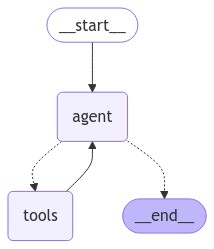

In [62]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [64]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "Is there discount on lemon?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Is there discount on lemon?
================================== Ai Message ==================================
Tool Calls:
  database_analyzer (call_nEA44gC7Ux7nVODnXGacjT7y)
 Call ID: call_nEA44gC7Ux7nVODnXGacjT7y
  Args:
    messages: [{'content': 'Is there a discount available on lemon?', 'type': 'human'}]
================================= Tool Message =================================
Name: database_analyzer

    product_id product_name category  price  discount discount_due_date
61      345678        Lemon   Fruits    1.0       NaN               NaN
================================== Ai Message ==================================

There is currently no discount available on lemons.


In [38]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "Is there any product on discount?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Is there any product on sale?
================================== Ai Message ==================================
Tool Calls:
  database_analyzer (call_dpTlSUi12UZvOoVJMObYqy6g)
 Call ID: call_dpTlSUi12UZvOoVJMObYqy6g
  Args:
    messages: [{'content': 'Can you provide information about any products currently on sale?', 'type': 'human'}]
================================= Tool Message =================================
Name: database_analyzer

    product_id        product_name category  price  discount
8       123457  Granny Smith Apple   Fruits   1.25      0.05
10      987654        Beef Sirloin     Meat  12.00      0.15
17      654322              Banana   Fruits   0.75      0.10
24      345678              Bagels   Bakery   4.50      0.25
39      526483    Multigrain Bread   Bakery   3.50      0.25
57      667788          Star Fruit   Fruits   2.50      0.18
58      123463               Mango   Fruits   2.

# Graph - not working!
Try reimplementing react_agent from source, and modify it.

In [58]:
import json
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage

model = ChatOpenAI(model="gpt-4o-mini")
tool_analyst = build_analyst_tool(warehouse, purchase_history)

model_with_tools = model.bind_tools(tools=[tool_analyst], tool_choice=tool_analyst.name)

system_prompt = "You are a good guy!"
prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessage(content=(system_prompt)),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

chain_with_tools = prompt | model_with_tool

In [59]:
response = chain_with_tools.invoke(["Is there any product on sale?"])

print(hasattr(response, "tool_calls"))
response.tool_calls

True


[{'name': 'database_analyzer',
  'args': {'messages': [{'content': 'Are there any products currently on sale in the inventory?',
     'type': 'human'}]},
  'id': 'call_nYtQ7Wmnmj5QTO4SvxobBx9S',
  'type': 'tool_call'}]

In [60]:
response = chain_with_tools.invoke(["How are you?"])

print(hasattr(response, "tool_calls"))
response.tool_calls

True


[{'name': 'database_analyzer',
  'args': {'messages': [{'content': "I'm just a computer program, so I don't have feelings, but I'm here and ready to assist you! How can I help you today?",
     'type': 'ai'}]},
  'id': 'call_uo8DPOwfltXDSysOpa4lN688',
  'type': 'tool_call'}]

In [45]:
# Create State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Add Chatbot Node
def chatbot(state: State):
    return {"messages": [model_with_tools.invoke(state["messages"])]}

In [64]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # print(tool_result)
            outputs.append(
                ToolMessage(
                    # content=json.dumps(tool_result),
                    content=tool_result,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

tool_node = BasicToolNode(tools=[tool_analyst])

In [65]:
from typing import Literal

def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

# Build graph
graph_builder = StateGraph(State)

# Define nodes
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

# Build graph
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {
        "tools": "tools", 
        "__end__": "__end__"
    },
)
graph_builder.add_edge("tools", "chatbot")
graph = graph_builder.compile()

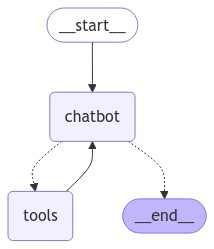

In [66]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
from langchain_core.messages import BaseMessage

while True:
    # user_input = input("User: ")
    user_input = "Is there any product on sale?"
    # user_input = ""
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)